<h2>Метод стрельбы<h2>

Рассмотрим задачу: $y'' = -\pi^2 y + \pi cos(\pi x)$

Граничные условия: y(0) + y'(0) = 0; y(1) = 0.5

Решение: y(x) = $-0.5 \cdot cos(\pi x) + 0.5/\pi \cdot sin(\pi x) + 1/2 \cdot xsin(\pi x)$


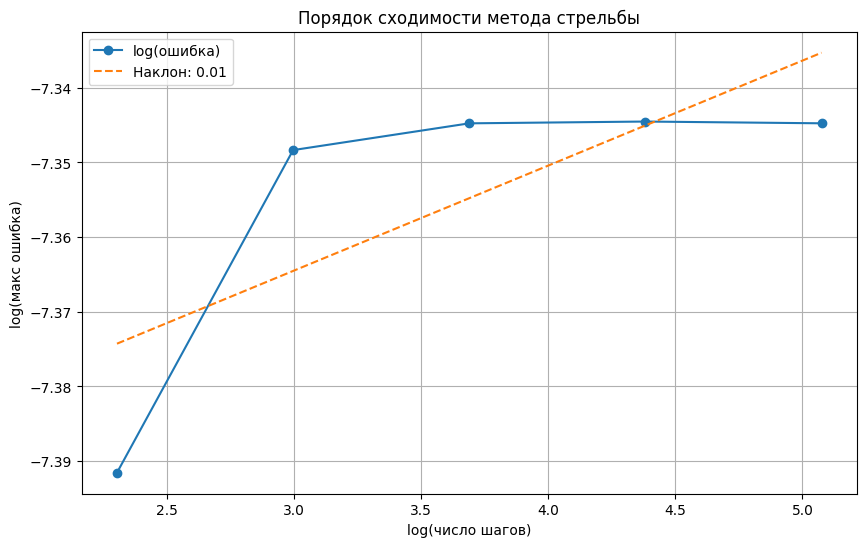

Порядок сходимости: 0.01
Найденное начальное значение y(0): -0.500257


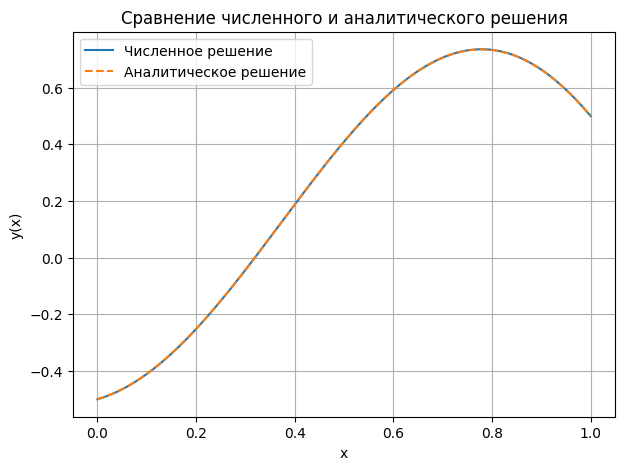

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt

def f(x, y, y1):
    return -np.pi**2 * y + np.pi * np.cos(np.pi * x)

def system(x, yz):
    y, z = yz
    return [z, f(x, y, z)]

def analytic(x):
    C1 = -0.5
    C2 = 0.5 / np.pi
    return C1 * np.cos(np.pi * x) + C2 * np.sin(np.pi * x) + 0.5 * x * np.sin(np.pi * x)

def shooting(s, steps):
    # y(0) = s, y'(0) = -s (из y(0) + y'(0) = 0 → y'(0) = -y(0))
    y0 = [s, -s]
    t_eval = np.linspace(0, 1, steps)
    sol = solve_ivp(system, [0, 1], y0, t_eval=t_eval)
    return sol

def boundary_residual(s, steps=160):
    sol = shooting(s, steps)
    return sol.y[0, -1] - 0.5 

def calculate_order():
    steps_array = np.array([10, 20, 40, 80, 160])
    errors = []

    for steps in steps_array:
        res = root_scalar(boundary_residual, bracket=[-1, 1], args=(steps,), method='brentq')
        s = res.root
        sol = shooting(s, steps)
        y_exact = analytic(sol.t)
        error = np.max(np.abs(y_exact - sol.y[0]))
        errors.append(error)

    log_steps = np.log(steps_array)
    log_errors = np.log(errors)
    slope, intercept, *_ = np.polyfit(log_steps, log_errors, 1)

    plt.figure(figsize=(10, 6))
    plt.plot(log_steps, log_errors, 'o-', label='log(ошибка)')
    plt.plot(log_steps, slope * log_steps + intercept, '--', label=f'Наклон: {slope:.2f}')
    plt.xlabel('log(число шагов)')
    plt.ylabel('log(макс ошибка)')
    plt.title('Порядок сходимости метода стрельбы')
    plt.legend()
    plt.grid(True)
    plt.show()

    return slope, s

if __name__ == "__main__":
    order, s_found = calculate_order()
    print(f"Порядок сходимости: {order:.2f}")
    print(f"Найденное начальное значение y(0): {s_found:.6f}")

    sol = shooting(s_found, 160)
    x_vals = sol.t
    y_exact = analytic(x_vals)

    plt.figure(figsize=(7,5))
    plt.plot(x_vals, sol.y[0], label='Численное решение')
    plt.plot(x_vals, y_exact, '--', label='Аналитическое решение')
    plt.legend()
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y(x)')
    plt.title('Сравнение численного и аналитического решения')
    plt.show()


<h2>Метод конечных разностей<h2>

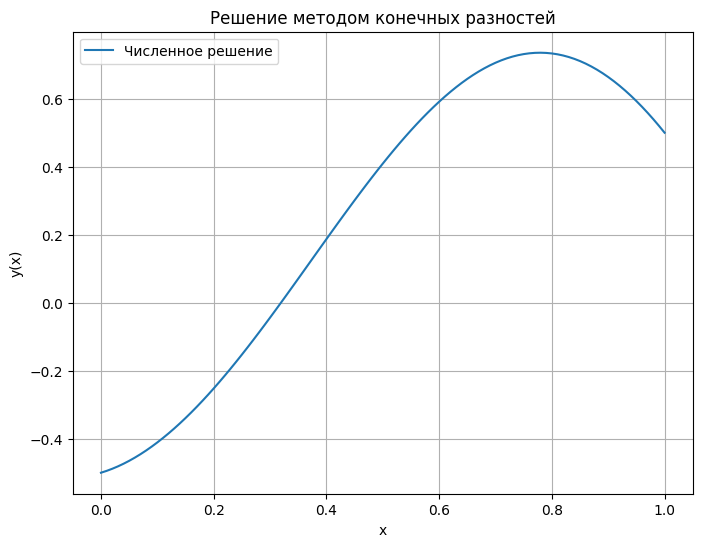

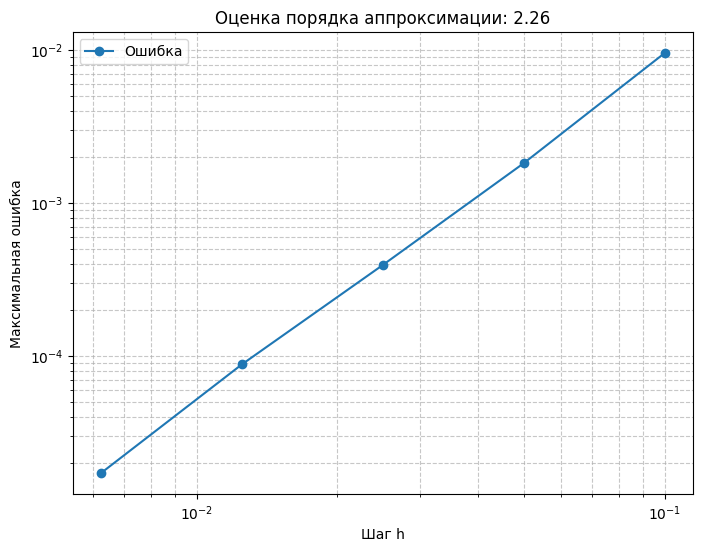

Оцененный порядок метода: 2.26


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def solve_finite_difference(N):
    h = 1 / N
    x = np.linspace(0, 1, N + 1)

    A = np.zeros((N + 1, N + 1))
    b = np.zeros(N + 1)

    # Внутренние узлы: y'' + π² y = π cos(π x)
    # y'' ≈ (y[i-1] - 2 y[i] + y[i+1]) / h²
    for i in range(1, N):
        A[i, i - 1] = 1 / h**2
        A[i, i]     = -2 / h**2 + np.pi**2
        A[i, i + 1] = 1 / h**2
        b[i] = np.pi * np.cos(np.pi * x[i])

    # Граничное условие в точке x=0: y(0) + y'(0) = 0
    # Аппроксимируем производную y'(0) ≈ (-3 y0 + 4 y1 - y2) / (2h)
    # Условие: y0 + y'(0) = 0 → y0 + (-3 y0 + 4 y1 - y2)/(2h) = 0
    A[0, 0] = 1 - 3 / (2 * h)
    A[0, 1] = 4 / (2 * h)
    A[0, 2] = -1 / (2 * h)
    b[0] = 0

    # Граничное условие в точке x=1: y(1) = 0.5
    A[N, N] = 1
    b[N] = 0.5

    y = np.linalg.solve(A, b)
    return x, y

def plot_solution(N=100):
    x, y_numeric = solve_finite_difference(N)

    plt.figure(figsize=(8, 6))
    plt.plot(x, y_numeric, '-', label="Численное решение", markersize=4)

    plt.xlabel("x")
    plt.ylabel("y(x)")
    plt.title("Решение методом конечных разностей")
    plt.legend()
    plt.grid(True)
    plt.show()

def estimate_order():
    N_values = [10, 20, 40, 80, 160, 320]
    h_values = [1 / N for N in N_values]
    errors = []

    x_ref, y_ref = solve_finite_difference(N_values[-1])

    for N in N_values[:-1]:
        x, y = solve_finite_difference(N)
        y_interp = np.interp(x, x_ref, y_ref)
        error = np.linalg.norm(y - y_interp, ord=np.inf)
        errors.append(error)

    log_h = np.log(h_values[:-1])
    log_err = np.log(errors)
    p = np.polyfit(log_h, log_err, 1)[0]

    plt.figure(figsize=(8, 6))
    plt.loglog(h_values[:-1], errors, '-o', label="Ошибка")
    plt.xlabel("Шаг h")
    plt.ylabel("Максимальная ошибка")
    plt.title(f"Оценка порядка аппроксимации: {p:.2f}")
    plt.grid(True, which="both", linestyle="--", alpha=0.7)
    plt.legend()
    plt.show()

    print(f"Оцененный порядок метода: {p:.2f}")

# === Основной блок ===
if __name__ == "__main__":
    plot_solution(N=100)
    estimate_order()


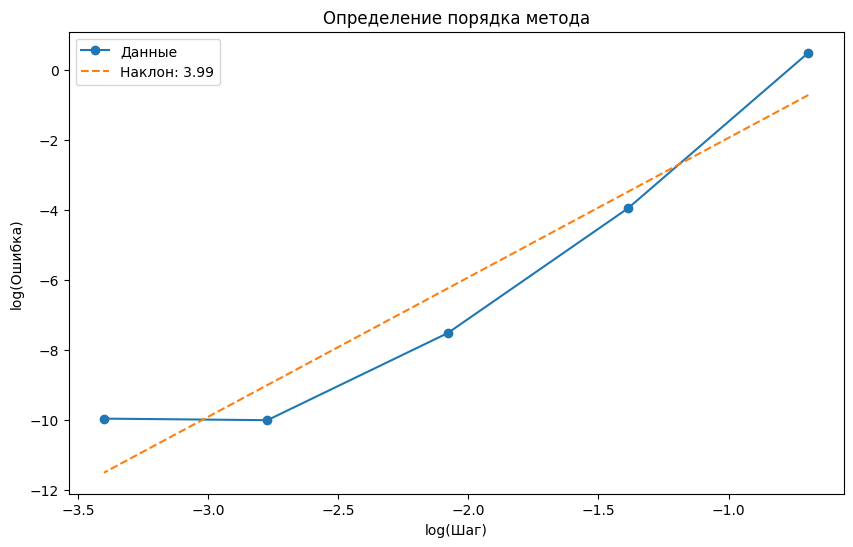

Расчетный порядок метода: 3.99


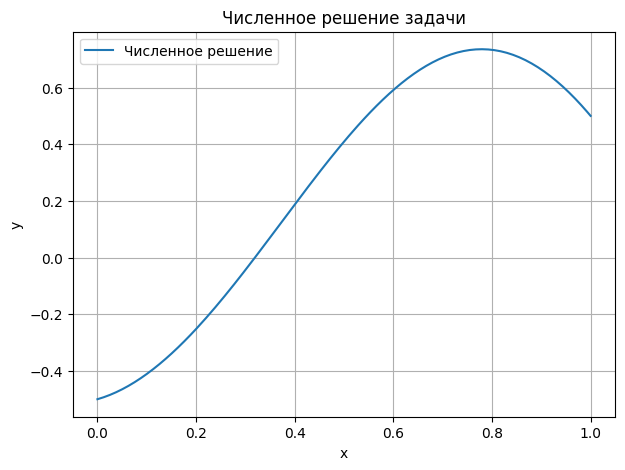

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Правая часть уравнения
def f(x, y, y1):
    return - (np.pi)**2 * y + np.pi * np.cos(np.pi * x)

# Система первого порядка
def system(x, yz):
    y, z = yz
    dydx = z
    dzdx = f(x, y, z)
    return np.array([dydx, dzdx])

# RK4 метод
def rk4(func, x_range, yz0, step):
    x_vals = np.linspace(x_range[0], x_range[1], step)
    h = x_vals[1] - x_vals[0]
    yz = np.array(yz0)
    y_vals = [yz[0]]

    for x in x_vals[:-1]:
        k1 = func(x, yz)
        k2 = func(x + h / 2, yz + h * k1 / 2)
        k3 = func(x + h / 2, yz + h * k2 / 2)
        k4 = func(x + h, yz + h * k3)
        yz = yz + h * (k1 + 2 * k2 + 2 * k3 + k4) / 6
        y_vals.append(yz[0])

    return np.array(x_vals), np.array(y_vals)

def shooting(s, step):
    yz0 = [s, -s]
    x_vals, y_vals = rk4(system, [0, 1], yz0, step)
    return x_vals, y_vals

# Поиск s методом Ньютона по граничному условию y(1) = 0.5
def find_s3_newton(tol=1e-10, max_iter=20):
    s = 0.0
    for _ in range(max_iter):
        _, y_vals = shooting(s, 160)
        f_s = y_vals[-1] - 0.5
        if abs(f_s) < tol:
            return s

        _, y_vals_plus = shooting(s + 1e-6, 160)
        df_ds = (y_vals_plus[-1] - y_vals[-1]) / 1e-6

        s -= f_s / df_ds

    print("Метод Ньютона не сходится")
    return s

def calculate_order():
    steps = np.array([2, 4, 8, 16, 30])
    errors = []

    s3 = find_s3_newton()

    for step in steps:
        x_vals, y_num = shooting(s3, step)
        x_ref, y_ref = shooting(s3, 160)
        y_exact = np.interp(x_vals, x_ref, y_ref)
        error = np.max(np.abs(y_exact - y_num))
        errors.append(error)

    errors = np.array(errors)
    errors[errors == 0] = 1e-16  # Чтобы избежать log(0)

    log_steps = np.log(1 / steps)
    log_errors = np.log(errors)
    coeffs = linregress(log_steps, log_errors)

    plt.figure(figsize=(10, 6))
    plt.plot(log_steps, log_errors, 'o-', label='Данные')
    plt.plot(log_steps, coeffs[0] * log_steps + coeffs[1], '--', label=f'Наклон: {coeffs[0]:.2f}')
    plt.xlabel('log(Шаг)')
    plt.ylabel('log(Ошибка)')
    plt.legend()
    plt.title('Определение порядка метода')
    plt.show()

    return coeffs[0]


order = calculate_order()
print(f"Расчетный порядок метода: {order:.2f}")

s3 = find_s3_newton()
x_vals, y_vals = shooting(s3, 160)

plt.figure(figsize=(7, 5), dpi=100)
plt.plot(x_vals, y_vals, label='Численное решение')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Численное решение задачи')
plt.grid(True)
plt.legend()
plt.show()
